### Optimization Algorithms
Trong notebook này, ta sẽ làm quen với 3 thuật toán tối ưu:
- AdaGrad
- RMSProp
- Adam

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/DL/Lesson3/DL-Thực hành ở nhà-03")
from d2l import tensorflow as d2l
import numpy as np
import tensorflow as tf

Mounted at /content/drive


In [ ]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')


def get_data(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [ ]:
def train_model(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Khởi tạo mô hình hồi quy tuyến tính
    w = tf.Variable(tf.random.normal(shape=(feature_dim, 1),
                                   mean=0, stddev=0.01),trainable=True)
    b = tf.Variable(tf.zeros(1), trainable=True)
  
    # Huấn luyện mô hình
    #Bước 1: Định nghĩa mô hình và hàm loss
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

    # Bước 2: Huấn luyện và trực quan hóa quá trình huấn luyện
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    
    for _ in range(num_epochs):
        for X, y in data_iter:
          with tf.GradientTape() as g:
            l = tf.math.reduce_mean(loss(net(X), y))
      
          dw, db = g.gradient(l, [w, b])
          trainer_fn([w, b], [dw, db], states, hyperparams)
          n += X.shape[0]
          if n % 200 == 0:
              timer.stop()
              p = n/X.shape[0]
              q = p/tf.data.experimental.cardinality(data_iter).numpy()
              r = (d2l.evaluate_loss(net, data_iter, loss),)
              animator.add(q, r)
              timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

In [ ]:
def train_keras(trainer_fn, hyperparams, data_iter, num_epochs=2):
    # Initialization
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, 
            kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    optimizer = trainer_fn(**hyperparams)
    loss = tf.keras.losses.MeanSquaredError()
  
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)/2
                params = net.trainable_variables
                grads = g.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                p = n/X.shape[0]
                q = p/tf.data.experimental.cardinality(data_iter).numpy()
                r = (d2l.evaluate_loss(net, data_iter, loss)/2,)
                animator.add(q, r)
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

## Phần 1: AdaGrad

### 1.1. Tự implement bằng tensorflow

Lập trình hai hàm sau đây:
- `init_adagrad_states`: Khởi tạo biến `states` cho hàm `adagrad`
- `adagrad`: Hàm thể hiện thuật toán tối ưu AdaGrad. Công thức như sau:
$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

In [ ]:
def init_adagrad_states(feature_dim):
    # YOUR CODE HERE
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

    # YOUR CODE HERE

def adagrad(params, grads, states, hyperparams):
    eps = 1e-6
    # YOUR CODE HERE
    for param, state, grad in zip(params, states, grads):
        state.assign(state + tf.math.square(grad))
        param.assign(param - hyperparams['lr'] * grad / tf.math.sqrt(state + eps))
    # YOUR CODE HERE

loss: 0.243, 0.057 sec/epoch


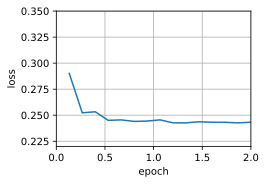

In [ ]:
data_iter, feature_dim = get_data(batch_size=10)
train_model(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### 1.2. Thực hiện thuật toán bằng hàm của keras

loss: 0.243, 0.074 sec/epoch


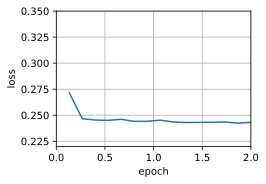

In [ ]:
# YOUR CODE HERE
trainer = tf.keras.optimizers.Adagrad
data_iter, _ = get_data(10)
# YOUR CODE HERE
train_keras(trainer, {'learning_rate' : 0.1}, data_iter)

## Phần 2: RMSProp

### 2.1. Tự implement bằng tensorflow
Lập trình hai hàm sau đây:
- `init_rmsprop_states`: Khởi tạo biến states cho hàm `rmsprop`.
- `rmsprop`: Hàm thể hiện thuật toán tối ưu RMSProp. Công thức như sau:

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

In [ ]:
def init_rmsprop_states(feature_dim):
    # YOUR CODE HERE
    s_w = tf.Variable(d2l.zeros((feature_dim, 1)))
    s_b = tf.Variable(d2l.zeros(1))

    # YOUR CODE HERE
    return (s_w, s_b)

In [ ]:
def rmsprop(params, grads, states, hyperparams):
    # YOUR CODE HERE
    eps = 1e-6
    # YOUR CODE HERE
    for param, state, grad in zip(params, states, grads):
        state.assign(hyperparams['gamma']*state + (1-hyperparams['gamma'])*tf.math.square(grad))
        param.assign(param - hyperparams['lr'] * grad / tf.math.sqrt(state + eps))
    # YOUR CODE HERE

loss: 0.244, 0.056 sec/epoch


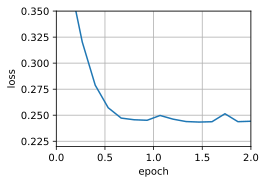

In [ ]:
data_iter, feature_dim = get_data(batch_size=10)
train_model(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

Expected output: `loss: 0.243, 0.068 sec/epoch`

### 2.2. Thực hiện thuật toán bằng hàm của keras

loss: 0.244, 0.095 sec/epoch


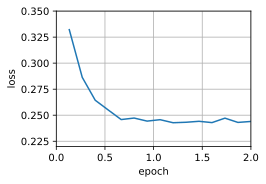

In [ ]:
# YOUR CODE HERE
trainer = tf.keras.optimizers.RMSprop
data_iter, _ = get_data(10)
# YOUR CODE HERE
train_keras(trainer, {'learning_rate': 0.01, 'rho': 0.9},
                       data_iter)

## Phần 3: Adam

### 3.1. Tự implement bằng tensorflow
Lập trình hai hàm sau đây:
- `init_adam_states`: Khởi tạo biến states cho hàm `adam`.
- `adam`: Hàm thể hiện thuật toán tối ưu Adam. Công thức như sau:


$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$


In [ ]:
def init_adam_states(feature_dim):
    # YOUR CODE HERE
    v_w = tf.Variable(d2l.zeros((feature_dim, 1)))
    v_b = tf.Variable(d2l.zeros(1))
    s_w = tf.Variable(d2l.zeros((feature_dim, 1)))
    s_b = tf.Variable(d2l.zeros(1))
    return ((v_w, s_w), (v_b, s_b))
    # YOUR CODE HERE

def adam(params, grads, states, hyperparams):
    # YOUR CODE HERE
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s), grad in zip(params, states, grads):
        v[:].assign(beta1 * v  + (1 - beta1) * grad)
        s[:].assign(beta2 * s + (1 - beta2) * tf.math.square(grad))
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:].assign(p - hyperparams['lr'] * v_bias_corr  
                    / tf.math.sqrt(s_bias_corr) + eps)

    # YOUR CODE HERE

loss: 0.243, 0.088 sec/epoch


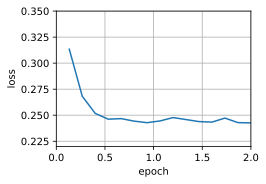

In [ ]:
data_iter, feature_dim = get_data(batch_size=10)
train_model(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

Expected output: `loss: 0.242, 0.088 sec/epoch`

### 3.2. Thực hiện thuật toán bằng hàm của keras

loss: 0.243, 0.080 sec/epoch


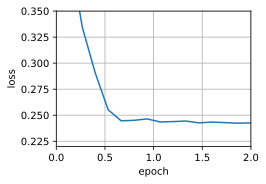

In [ ]:
# YOUR CODE HERE
trainer = tf.keras.optimizers.Adam
# YOUR CODE HERE
train_keras(trainer, {'learning_rate': 0.01}, data_iter)